In [33]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
%matplotlib inline

In [34]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

train_x = train_x.astype(np.float32) /255.0
test_x = test_x.astype(np.float32) /255.0

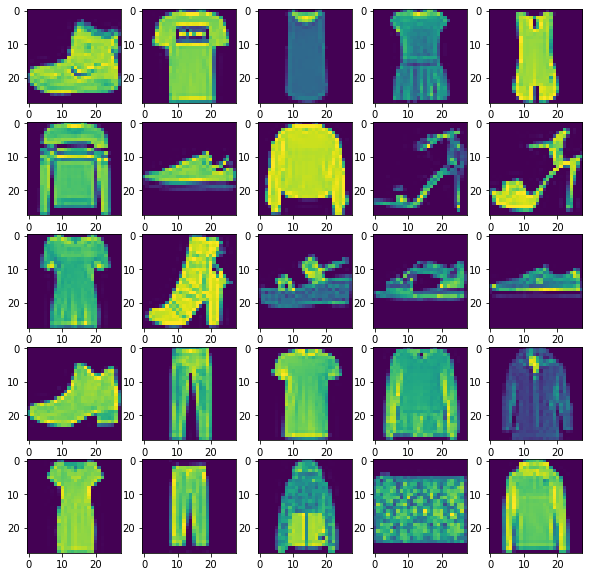

In [35]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[i])
plt.show()

In [36]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(1000)
dataset.batch(batch_size, drop_remainder=True).prefetch(1)

<PrefetchDataset shapes: (32, 28, 28), types: tf.float32>

In [80]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

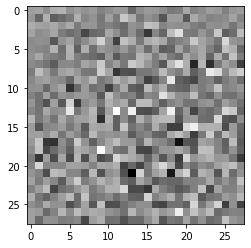

In [83]:
noise = tf.random.normal(shape=[1, num_features])
generated_img = generator(noise, training=False)
plt.imshow((tf.reshape(generated_img[0], (28,28))), cmap=plt.cm.binary)
plt.show()

In [84]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [90]:
decision = discriminator(generated_img)
print(decision)

tf.Tensor([[0.49800315]], shape=(1, 1), dtype=float32)


In [91]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

In [92]:
gan = keras.models.Sequential([
    generator,
    discriminator
])

gan.compile(loss='binary_crossentropy', optimizer='rmsprop')
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


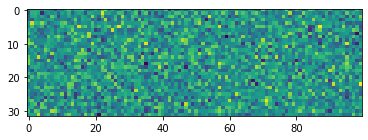

In [95]:
seed = tf.random.normal(shape=[batch_size, num_features])
plt.imshow(seed)

In [113]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_img = generator(noise)
            X_fake_n_real = tf.concat([generated_img, X_batch], axis=0)
            y1 = tf.concat([[[0.]] * batch_size + [[1.]] * batch_size], axis=0)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_n_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [114]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [115]:
x_train_dcgan = train_x.reshape(-1, 28, 28, 1) * 2. -1.

In [116]:
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

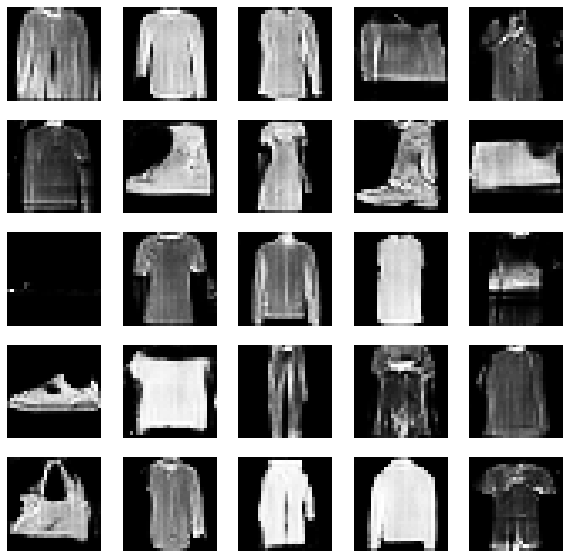

Wall time: 24min 56s


In [118]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

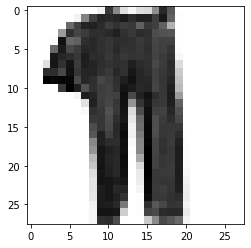

In [125]:
noise = tf.random.normal(shape=[1, num_features])
generated_img = generator(noise, training=False)
plt.imshow((tf.reshape(generated_img[0], (28,28))), cmap=plt.cm.binary)
plt.show()

In [131]:
decision = discriminator(generated_img)
print(decision)

tf.Tensor([[0.6308384]], shape=(1, 1), dtype=float32)
